---
# title: "My Notebook"
format:
  html:
    toc: true           # ✅ Table of contents (outline)
    toc-location: left  # ✅ Place TOC in the left sidebar
    number-sections: true
    code-fold: true
    code-summary: "Show Code"
    theme: cosmo        # Optional themes: cosmo, flatly, default, etc.
---

# Week 5B: Flood Modeling based on Raster data
Sep 25, 2025


Major topic:
- Download the DEM data
- Visualize the DEM data
- Conduct the flood modeling analysis based on DEM

## Major topics
Urban flooding is one of the major hazard. Here we can use the digital elevation model (DEM) to evaluate the potential flooded area. 

- Download the DEM data
- Visualize the DEM data
- Conduct the hydrological analysis based on DEM

### Download the DEM automatically from USGS
All the Digital Elevation Model *(DEM)* data can be downloaded from the USGS website: ([Link](https://apps.nationalmap.gov/downloader/)). 

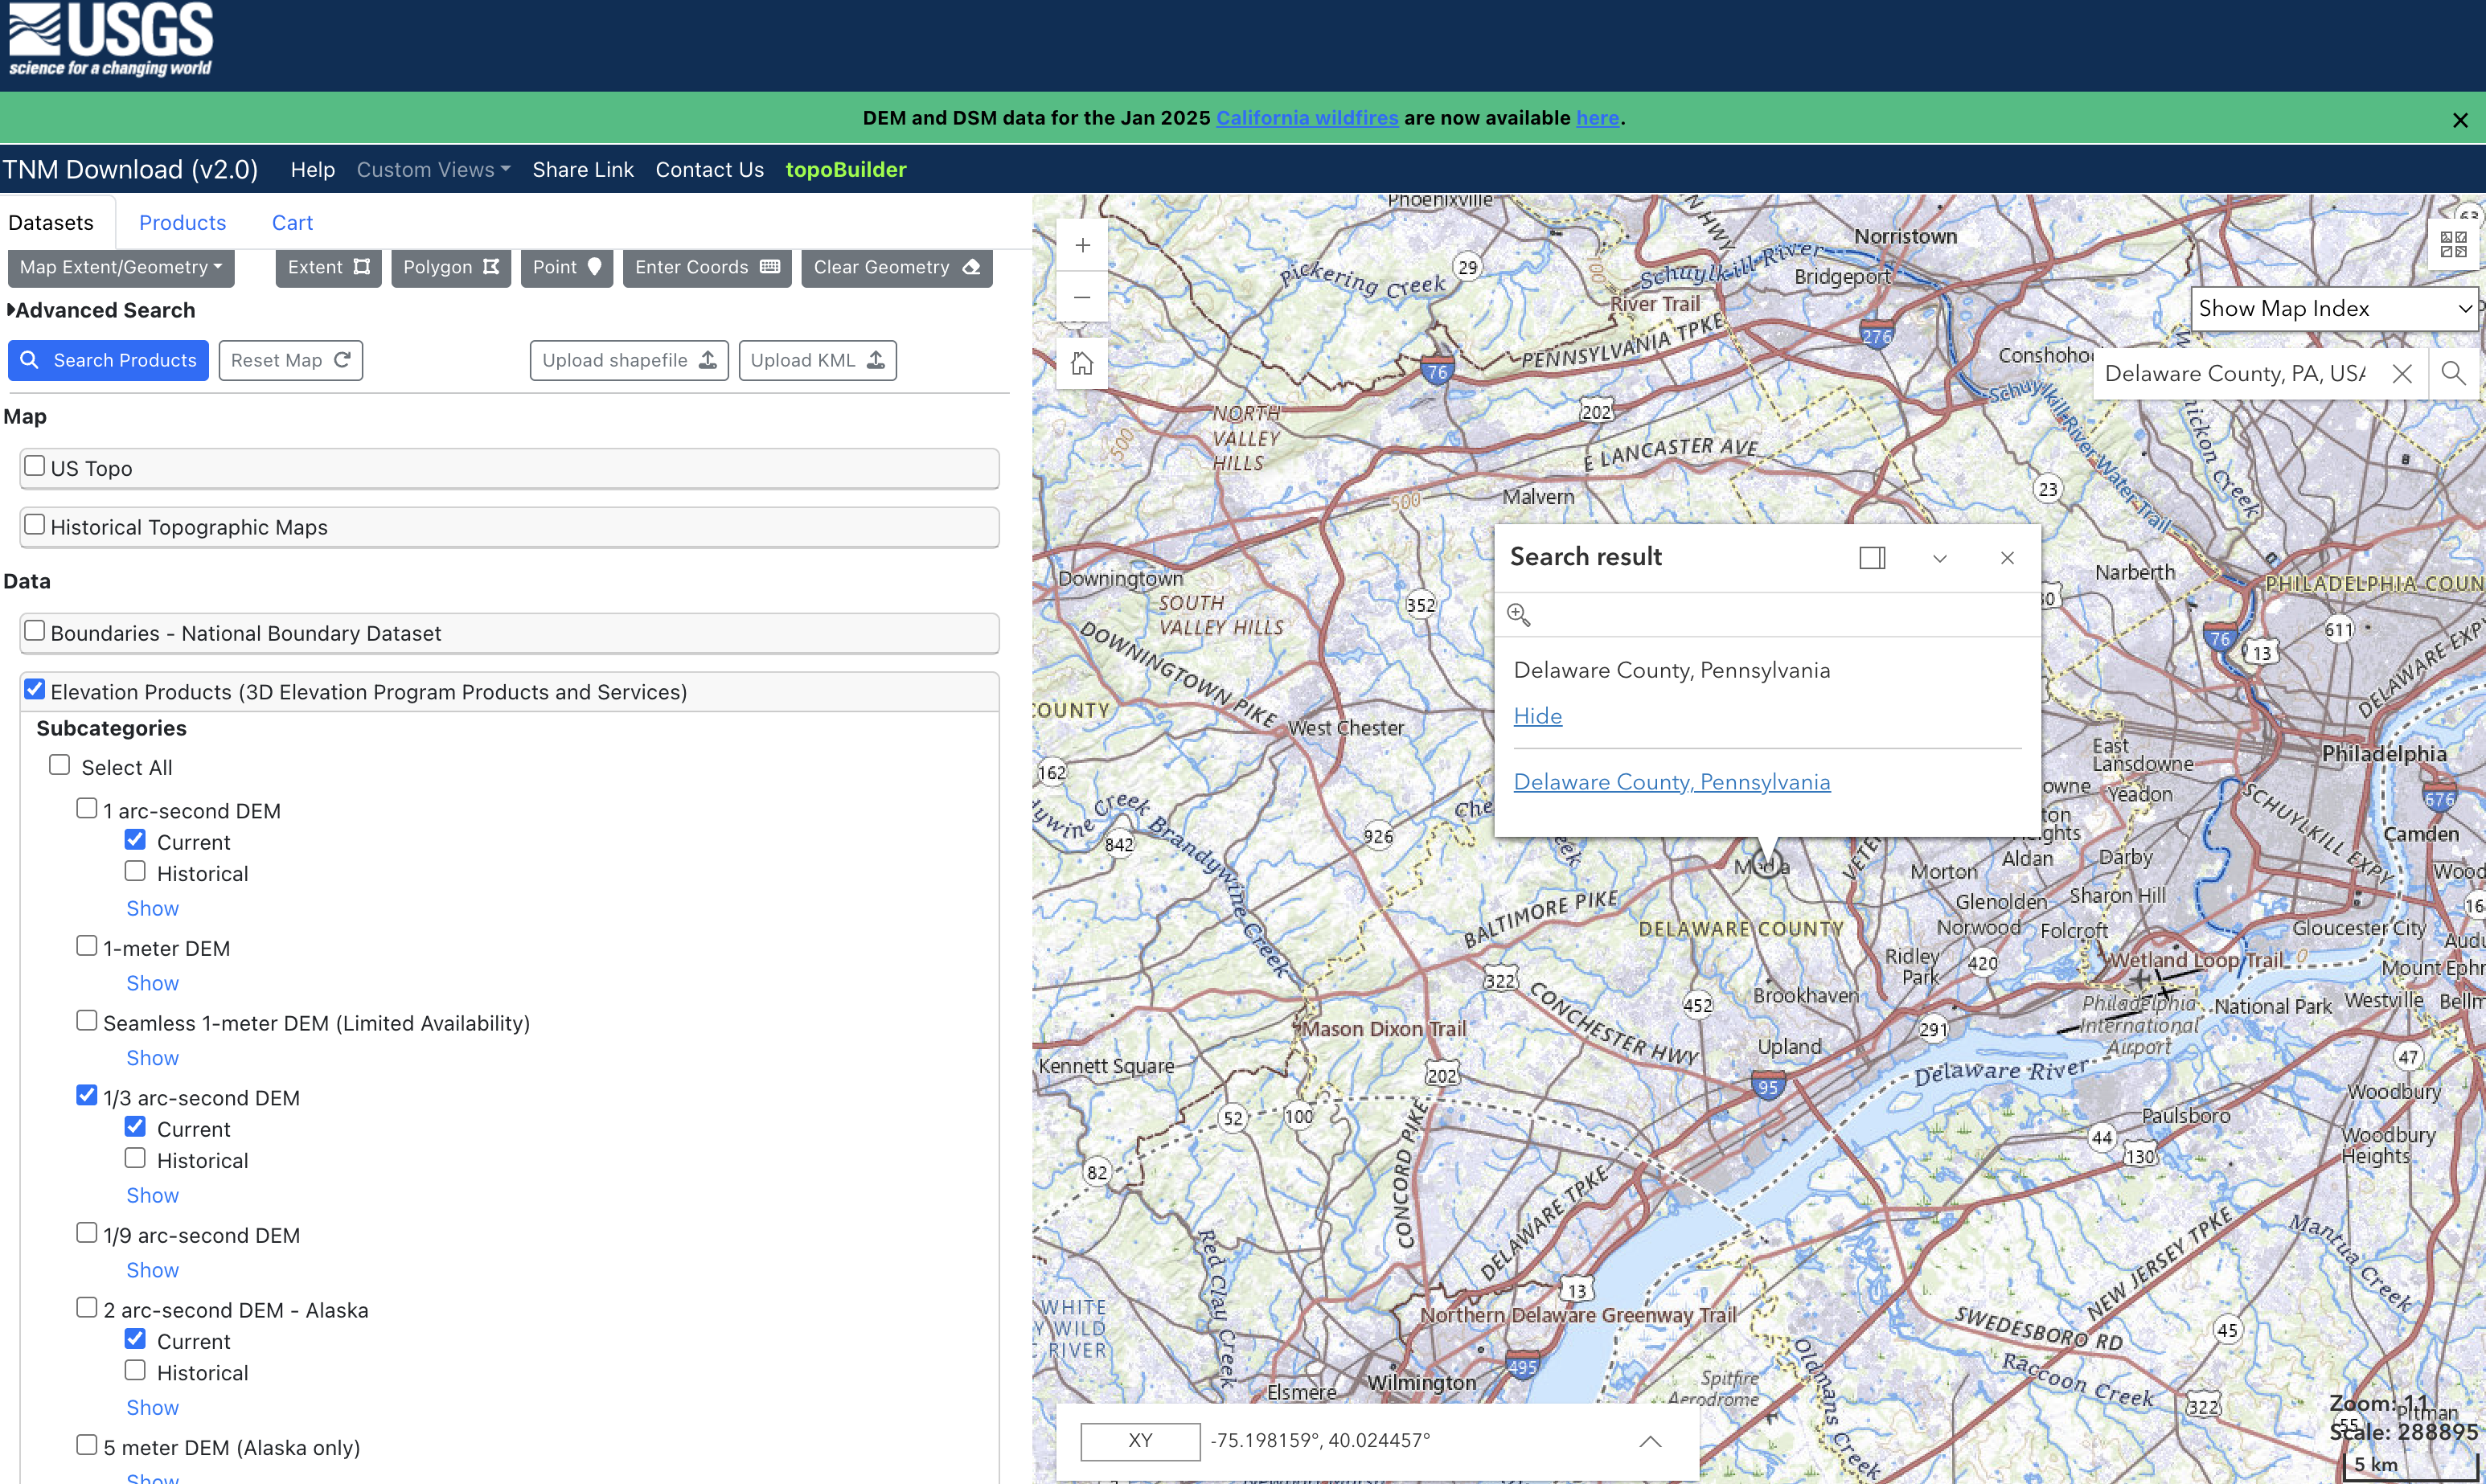

On USGS website, there are DEM data with different resolution. The higher resolution DEM data can provide more accurate elevation information, but the file size is larger.

An arc second is equivalent to 1/3600th of 1 degree or equal to 1/1,296,000 of a full circle.

- 1-arc-second (~30m)	`Elevation/1/TIFF/current/`
- 1/3-arc-second (~10m)	`Elevation/13/TIFF/current/`
- 1/9-arc-second (~3m)	`Elevation/19/TIFF/current/`

- 1m resolution DEM  `https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/TIFF/current/{tile_name}/USGS_1m_{tile_name}.tif`

**For example**, `n40w076` → Represents the latitude (40°N) and longitude (76°W) of the bottom-left corner. `USGS_1_n40w076.tif` → USGS 1-arcsecond DEM for that region. To get a different tile, change `n40w076` in the URL to the coordinates of your area of interest.

### Download a sample DEM for one tile

Let get started to download one DEM tile, 

In [1]:
import requests

# you can try different tiles
tile_name = 'n38w105'
tile_name = 'n39w076'
tile_name = 'n40w076'

# Example download URL for a tile, here the 1 mean 1-arc second DEM, resolution around 30m
tile_url = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current/%s/USGS_1_%s.tif"%(tile_name, tile_name)

# Download the tile
response = requests.get(tile_url)

with open("%s.tif"%(tile_name), "wb") as file:
    file.write(response.content)

print("DEM tile downloaded: %s.tif"%(tile_name))


DEM tile downloaded: n40w076.tif


In [4]:
tile_url

'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current/n40w076/USGS_1_n40w076.tif'

You can also open the url address in your web browser to download the data. What we are doing here actually is to use Pyton to automate the downloading process.


### Let organize the script using function
Create a function `download_dem` to download the DEM data based on the tile name and resolution. The input parameters are are the lat and lon of any potential location. 

In [2]:
def get_tile_name(lat, lon):
    """
    Returns the USGS tile name formatted correctly (e.g., 'n39w076').
    """
    lat_tile = f"n{int(abs(lat)):02d}" if lat >= 0 else f"s{int(abs(lat)):02d}"
    lon_tile = f"w{int(abs(lon)):03d}" if lon < 0 else f"e{int(abs(lon)):03d}"
    return f"{lat_tile}{lon_tile}"

# Example: Get tile for Philadelphia (39.95°N, 75.16°W)
lat, lon = 39.95, -75.16
tile_name = get_tile_name(lat, lon)
print("DEM Tile Name:", tile_name)

DEM Tile Name: n39w075


Through this function, you can typein any coordinate and find the tile name of the DEM tiles in the USGS server.

### List all DEM tiles for a region

You probably want to download multiple tiles for a region. Here are can specify the boundary of the region and download all the tiles in that region.Here we create a function to return all the tile names in a region. 

In [5]:
def get_tiles_in_bbox(min_lat, max_lat, min_lon, max_lon):
    """
    Returns a list of tile names covering a bounding box.
    """
    tile_list = []
    for lat in range(int(min_lat), int(max_lat) + 1):
        for lon in range(int(min_lon), int(max_lon) + 1):
            tile_list.append(get_tile_name(lat, lon))
    return tile_list

# Example: Get tiles for an area (Philadelphia to NYC region)
tiles = get_tiles_in_bbox(38, 41, -76, -74)
print("Tiles to Download:", tiles)

Tiles to Download: ['n38w076', 'n38w075', 'n38w074', 'n39w076', 'n39w075', 'n39w074', 'n40w076', 'n40w075', 'n40w074', 'n41w076', 'n41w075', 'n41w074']


Through this function, you can typein any boundary and find all the tile names of the DEM tiles in the USGS server.

### Now we can start to download in batch

In [51]:
import requests
import os

def download_dem_1arc(tile_name, save_path="."):
    """
    Downloads a 1-arc-second (~30m) DEM tile from USGS TNM.
    
    Parameters:
        tile_name (str): Tile name (e.g., "n39w076").
        save_path (str): Directory to save the DEM file.
    """
    base_url = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current"
    url = f"{base_url}/{tile_name}/USGS_1_{tile_name}.tif"
    
    output_file = os.path.join(save_path, f"{tile_name}.tif")
    
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        # with open(output_file, "wb") as file:
        #     for chunk in response.iter_content(1024):
        #         file.write(chunk)
        print(f"✅ DEM Tile {tile_name} downloaded successfully!")
    else:
        print(f"❌ Error: Tile {tile_name} not found. Check availability.")
        print(url)
        
# Download multiple tiles
save_directory = "DEM_Tiles"
os.makedirs(save_directory, exist_ok=True)  # Create folder if it doesn't exist


for tile in tiles:
    download_dem_1arc(tile, save_directory)

✅ DEM Tile n38w076 downloaded successfully!
❌ Error: Tile n38w075 not found. Check availability.
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current/n38w075/USGS_1_n38w075.tif
❌ Error: Tile n38w074 not found. Check availability.
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current/n38w074/USGS_1_n38w074.tif
✅ DEM Tile n39w076 downloaded successfully!
✅ DEM Tile n39w075 downloaded successfully!
❌ Error: Tile n39w074 not found. Check availability.
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current/n39w074/USGS_1_n39w074.tif
✅ DEM Tile n40w076 downloaded successfully!
✅ DEM Tile n40w075 downloaded successfully!
❌ Error: Tile n40w074 not found. Check availability.
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current/n40w074/USGS_1_n40w074.tif
✅ DEM Tile n41w076 downloaded successfully!
✅ DEM Tile n41w075 downloaded successfully!
✅ DEM Tile n41w074 downloaded successfully!


## Visualize the DEM

We have not check our downloaded DEM data yet. Let use Python to visualize the DEM data.

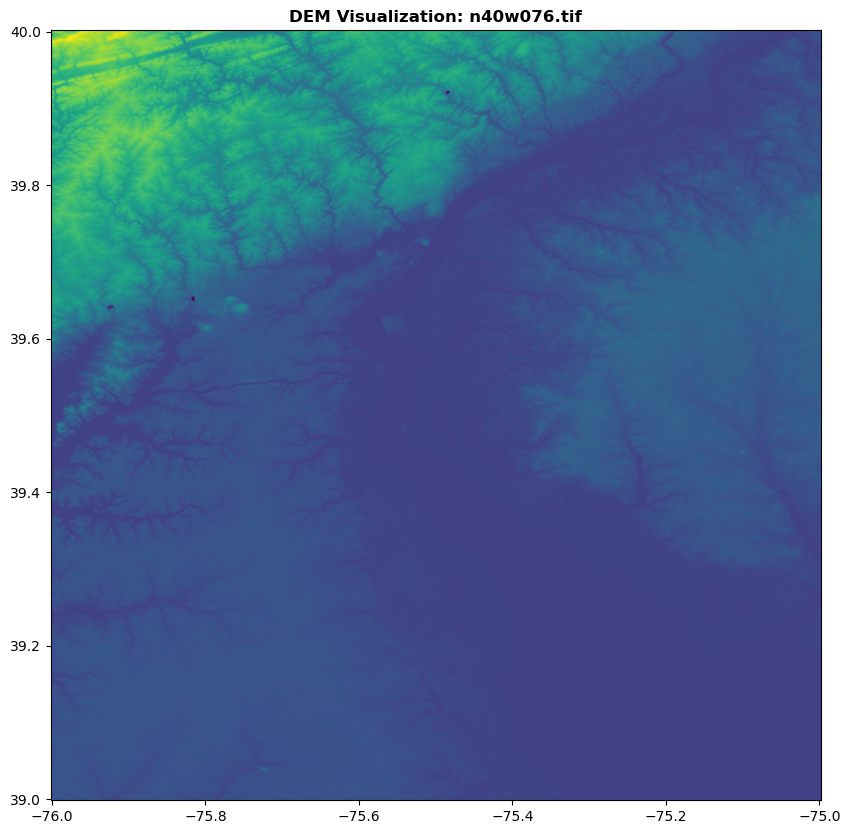

In [6]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

def visualize_dem(file_path):
    """
    Visualizes the downloaded DEM tile using rasterio and matplotlib.

    Parameters:
        file_path (str): Path to the DEM file to be visualized.
    """
    with rasterio.open(file_path) as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        show(src, ax=ax, title=f"DEM Visualization: {file_path}")
        plt.show()

# Visualize a downloaded DEM tile
dem_file = 'n40w076.tif'
visualize_dem(dem_file)

## Flood modeling analysis

Inundation Risk Modelling With HAND Model using PySheds
This notebook demonstrates flood risk assessment using the Height Above Nearest Drainage (HAND) model. By using Digital Elevation Models (DEMs) and calculating the vertical distance of terrain points from the drainage network, the HAND model helps classify areas based on their flood risk potential. The workflow is implemented with Python libraries such as rasterio, numpy, Pysheds, and matplotlib. The notebook covers data preparation, HAND calculation, and flood risk classification with clear, reproducible steps.

With consideration of rainfall and terrain involves leveraging the library’s capabilities for flow direction, flow accumulation, and watershed delineation from a Digital Elevation Model (DEM). Here’s a step-by-step guide:

Reference: [https://mattbartos.com/pysheds/hand.html](https://mattbartos.com/pysheds/hand.html)

Pysheds, [https://mattbartos.com/pysheds/](https://mattbartos.com/pysheds/)

### Install the module of `pysheds`
We need to install the `pysheds` module first. You can use the following command to install it. 

In [8]:
# !pip install pysheds
# !pip install seaborn

In [20]:
import numpy as np
import pysheds
from pysheds.grid import Grid

print("You have imported pysheds successfully!")

You have imported pysheds successfully!


Open the DEM tile file using `pysheds`

In [19]:
# Instantiate grid from raster
dem_file = 'n40w076.tif'
grid = Grid.from_raster(dem_file)
dem = grid.read_raster(dem_file)
dem.shape, type(dem)

((3612, 3612), pysheds.sview.Raster)

### computing the flow directions and accumulation for a given DEM
You can download the DEM file from here

In [11]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [12]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

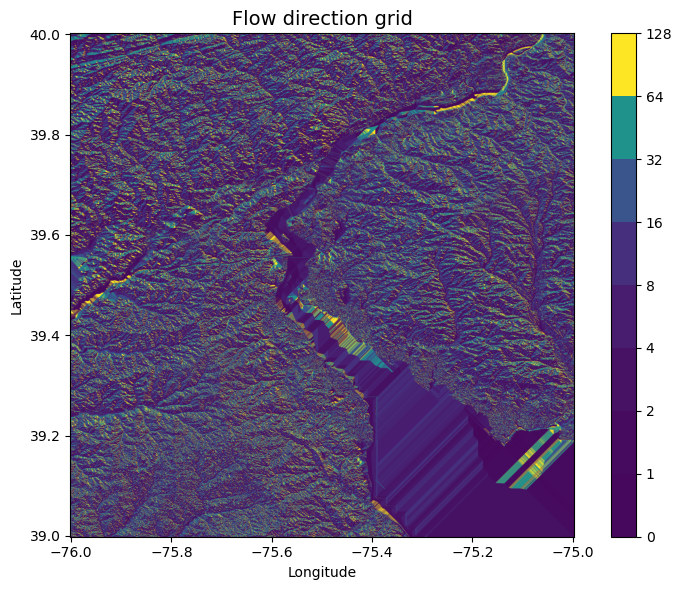

In [13]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

### Compute accumulation from flow direction

In [14]:

# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

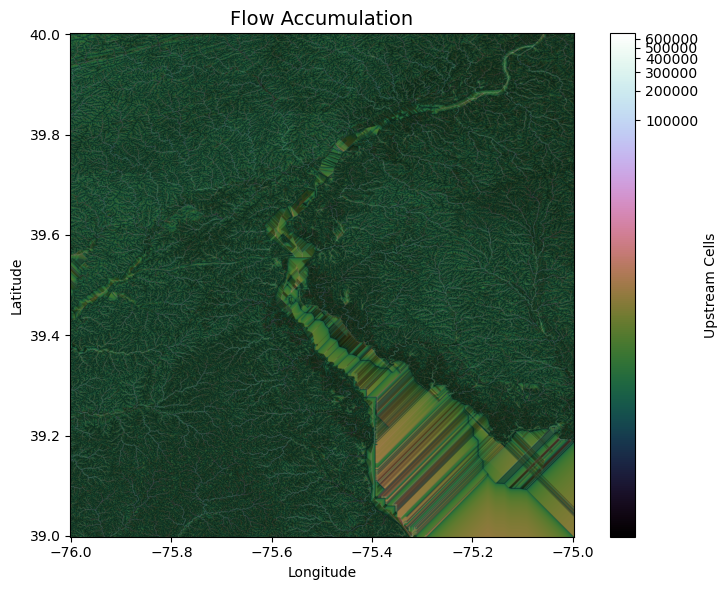

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors


fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.PowerNorm(gamma=0.1, vmin=acc.min(), vmax=acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

### Compute the height above nearest drainage


In [16]:
# Compute height above nearest drainage
hand = grid.compute_hand(fdir, dem, acc > 200)

### Estimating inundation extent (constant channel depth)


In [17]:
threshold = 5
inundation_extent = np.where(hand < threshold, threshold - hand, np.nan)

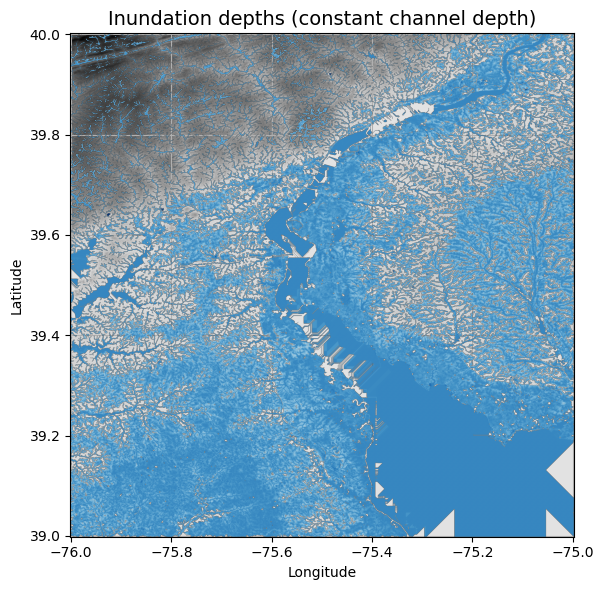

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
dem_view = grid.view(dem, nodata=np.nan)
plt.imshow(dem_view, extent=grid.extent, cmap='Greys', zorder=1)
plt.imshow(inundation_extent, extent=grid.extent,
           cmap='Blues', vmin=-5, vmax=10, zorder=2)
plt.grid(zorder=0)
plt.title('Inundation depths (constant channel depth)', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()